# Recitation 4
### 14.Oct.22
#### Mariana Martínez Aguilar

Today's recitation has two parts: first we are going to compare some Newton's methods again with the Rosenbrock function and then we are going to use them to compute the minimum of a more interesting function.

### Rosenbrock function
In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function.

The global minimum is inside a long, narrow, parabolic shaped flat valley. To find the valley is trivial. To converge to the global minimum, however, is difficult.

The function originally has two parameters, $a$ and $b$ but in this case we will set $a = 1$ and $b = 5$. We know that the global optimum is found in $(a, a^2)$. The function in our case is:

$$ f(x, y) = (a - x)^2 + b(y - x^2)^2 = (1 - x)^2 + 5(y - x^2)^2. $$ 

### Steepest descent, Newton's method, Broyden, SR1, and BFGS

Now define 3 functions to minimize the Rosenbrock function, one should use steepest descent, the other one should use Newton's method, the other one should use Broyden's method, one using SR1, and the last one using the BFGS update. What are the ingredients for each method?

In [1]:
# We've done this before

import numpy as np
import matplotlib.pyplot as plt
import colorcet as cc 
from numpy.linalg import norm, inv

a = 1.25
b = 0.25

def Ros(x, y):
    '''
    Rosenbrock function with parameters a = 1, b = 5
    '''
    return np.power(a-x,2) + b*np.power( np.subtract(y, np.power(x,2)), 2 )

# START PLOTTING

# 2D

Nx = 1000
Ny = 1000


# First plot

x, y = np.meshgrid( np.linspace(-2, 2, Nx), np.linspace(-2, 2, Ny) )
z = Ros(x, y)

# We need the gradient, backtracking, and the Hessian
from math import sqrt

def gradRosenbrock(x, y):
    '''
    Gradient of the Rosenbrock function
    '''
    grad = np.zeros((2, 1))
    grad[0] = -2*a + 4*b*x**3 - 4*b*x*y + 2*x
    grad[1] = 2*b*(y-x**2)
    return grad

def backTr(alpha, xn, yn, direction):
    '''
    Backtracking algorithm
    '''
    Fn = Ros(xn, yn) # function value of previous iteration
    xn_1 = xn + alpha*direction[0, 0]
    yn_1 = yn + alpha*direction[1, 0]
    Fn_1 = Ros(xn_1, yn_1) # function value of possible next iteration
    while Fn < Fn_1:
        alpha = alpha*beta
        xn_1 = xn + alpha*direction[0,0]
        yn_1 = yn + alpha*direction[1,0]
        Fn_1 = Ros(xn_1, yn_1) # Try again
    return alpha

def HessRosenbrock(x, y):
    '''
    Hessian of the Rosenbrock function
    '''
    Hess = np.zeros((2,2))
    Hess[0,0] = 12*b*x**2 - 4*b*y + 2 
    Hess[0,1] = -4*b*x # mixed partials
    Hess[1,0] = -4*b*x # mixed partials
    Hess[1,1] = 2*b
    return Hess




In [2]:
# Now we can define the 3 functions

##################################################
########### STEEPEST DESCENT
def steepDesc_Ros(x0, y0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using the steepest descent direction
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    d = -gradRosenbrock(xn, yn)
    while( norm(d) >= tol and i < maxIter ):
        d = -gradRosenbrock(xn, yn)
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i


##################################################
########### NEWTON'S METHOD

def newton_Ros(x0, y0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using Newton's method
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = -gradRosenbrock(xn, yn)
    while( norm(g) >= tol and i < maxIter ):
        Hess = HessRosenbrock(xn, yn) # In this method we do need the hessian
        g = gradRosenbrock(xn, yn)
        d = -inv(Hess)*g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i


##################################################
########### BROYDEN'S METHOD

def broyden_Ros(x0, y0, B0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using Broyden's update to the
    Hessian (i.e. we don't compute the Hessian on
    each step)
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = gradRosenbrock(xn, yn)
    sk = np.ones(g.shape)
    Bk = B0
    while( norm(g) >= tol and i < maxIter and norm(sk) >= tol ):
        d = -inv(Bk)@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        # Now we need to update the Hessian approximation using Broyden's formula
        # We need the parameters sk and yk (as in Nocedal or Griva)
        gnew = gradRosenbrock(xn, yn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        Bk = Bk + (1/(sk@sk.T))*(yk - Bk@sk)*sk.T # Broyden's formula
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        g = gnew
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i

##################################################
########### SR1

def sr1_Ros(x0, y0, H0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using the SR1 update to the INVERSE
    of the Hessian
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = gradRosenbrock(xn, yn)
    sk = np.ones(g.shape)
    Hk = H0
    frac = 1
    while( norm(g) >= tol and i < maxIter and norm(frac) >= tol ):
        d = -Hk@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        gnew = gradRosenbrock(xn, yn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        frac = (sk - Hk@yk).T@yk
        Hk = Hk + (1/(frac)) * (sk - Hk@yk)@(sk - Hk@yk).T # SR1 formula
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        g = gnew
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i
                   
##################################################
########### BFGS

def bfgs_Ros(x0, y0, H0):
    '''
    Function that minimizes the Rosenbrock function
    in free space using the BFGS update to the INVERSE
    of the Hessian
    '''
    xn_vec = [x0]
    yn_vec = [y0]
    F_vec = [Ros(x0, y0)]
    xn, yn = x0, y0
    i = 0
    g = gradRosenbrock(xn, yn)
    sk = np.ones(g.shape)
    Hk = H0
    I = np.identity(2) # Useful to have for the BFGS update
    rho_inv = 1
    while( norm(g) >= tol and i < maxIter and norm(rho_inv) >= tol ):
        d = -Hk@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, yn, d)
        xn, yn = xn + alpha*d[0,0], yn + alpha*d[1, 0]
        gnew = gradRosenbrock(xn, yn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        rho_inv = yk.T@sk
        Hk = (I - 1/rho_inv*sk@yk.T)@Hk@(I - 1/rho_inv*yk@sk.T) + 1/rho_inv*sk@sk.T # BFGS formula
        xn_vec.append(xn)
        yn_vec.append(yn)
        F_vec.append(Ros(xn, yn))
        g = gnew
        i += 1
    return (xn, yn), xn_vec, yn_vec, F_vec, i




Values found with steepest 1.2499999999997575 1.5624999999984854
Optimal with Steepest 2.6508360471292336e-25
Number of iterations 402



Values found with Newton 1.2499999999998619 1.5625000000000917
Optimal with Newton 6.681356044382512e-26
Number of iterations 267



Values found with Broyden 1.4047619047619047 1.9642857142857137
Optimal with Newton 0.023971814727402643
Number of iterations 2



Values found with SR1 1.2500000043045085 1.5625000052326874
Optimal with Newton 2.6170104020504775e-17
Number of iterations 6



Values found with BFGS 1.2500000000000002 1.5624999999999996
Optimal with Newton 3.5745259767827097e-31
Number of iterations 7


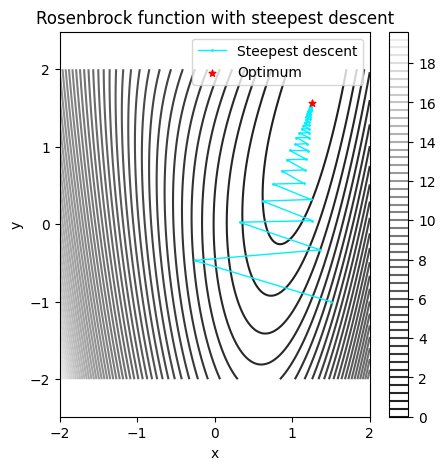

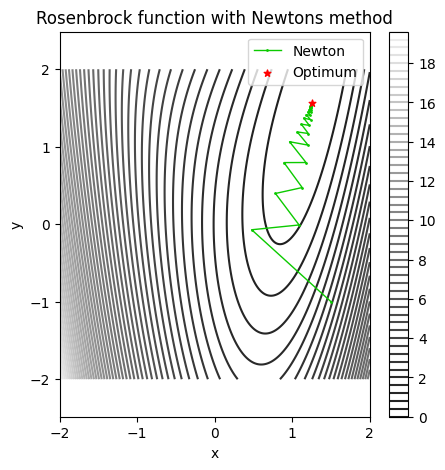

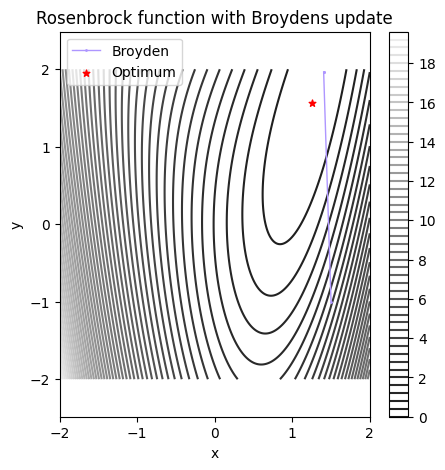

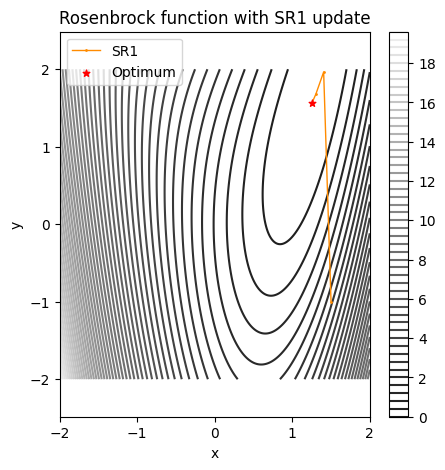

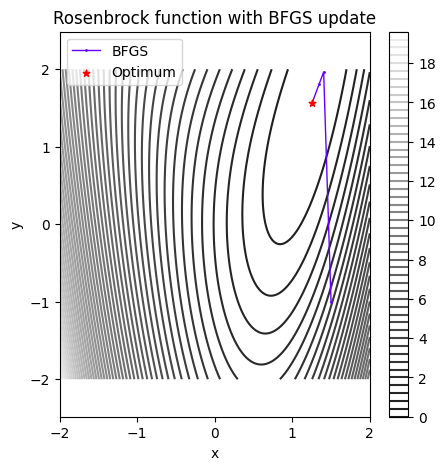

In [3]:
# We need to define the following parameters

maxIter = 1000
alpha0 = 1
beta = 0.8
tol = 1e-12
x0 = 1.5
y0 = -1
B0 = HessRosenbrock(x0, y0)
H0 = inv(B0)

# Steepest descent
(xn_S, yn_S), xn_vec_S, yn_vec_S, F_vec_S, i_S = steepDesc_Ros(x0, y0)
print("\n\n\nValues found with steepest", xn_S, yn_S)
print("Optimal with Steepest", Ros(xn_S, yn_S))
print("Number of iterations", i_S)

# Newton

(xn_N, yn_N), xn_vec_N, yn_vec_N, F_vec_N, i_N = newton_Ros(x0, y0)
print("\n\n\nValues found with Newton", xn_N, yn_N)
print("Optimal with Newton", Ros(xn_N, yn_N))
print("Number of iterations", i_N)

# Broyden

(xn_B, yn_B), xn_vec_B, yn_vec_B, F_vec_B, i_B = broyden_Ros(x0, y0, B0)
print("\n\n\nValues found with Broyden", xn_B, yn_B)
print("Optimal with Newton", Ros(xn_B, yn_B))
print("Number of iterations", i_B)

# SR1

(xn_SR1, yn_SR1), xn_vec_SR1, yn_vec_SR1, F_vec_SR1, i_SR1 = sr1_Ros(x0, y0, H0)
print("\n\n\nValues found with SR1", xn_SR1, yn_SR1)
print("Optimal with Newton", Ros(xn_SR1, yn_SR1))
print("Number of iterations", i_SR1)

# BFGS

(xn_BFGS, yn_BFGS), xn_vec_BFGS, yn_vec_BFGS, F_vec_BFGS, i_BFGS = bfgs_Ros(x0, y0, H0)
print("\n\n\nValues found with BFGS", xn_BFGS, yn_BFGS)
print("Optimal with Newton", Ros(xn_BFGS, yn_BFGS))
print("Number of iterations", i_BFGS)

# Plot the trajectories

plt.figure(figsize = (5, 5))
im2 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with steepest descent') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_S, yn_vec_S, marker = '.', markersize = 2, 
        linewidth = 1, c = "#00f0ff", label = "Steepest descent")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im2)


plt.figure(figsize = (5, 5))
im3 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with Newtons method') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_N, yn_vec_N, marker = '.', markersize = 2, 
        linewidth = 1, c = '#0cca00', label = "Newton")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im3)


plt.figure(figsize = (5, 5))
im4 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with Broydens update') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_B, yn_vec_B, marker = '.', markersize = 2, 
        linewidth = 1, c = "#ae96ff", label = "Broyden")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im4)




plt.figure(figsize = (5, 5))
im5 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with SR1 update') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_SR1, yn_vec_SR1, marker = '.', markersize = 2, 
        linewidth = 1, c = "#ff8b00", label = "SR1")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im5)




plt.figure(figsize = (5, 5))
im6 = plt.contour( x, y,z, levels = 50, 
                  cmap = 'cet_linear_grey_10_95_c0') 
plt.axis('equal')
plt.title('Rosenbrock function with BFGS update') 
plt.xlabel('x')
plt.ylabel('y')
plt.plot(xn_vec_BFGS, yn_vec_BFGS, marker = '.', markersize = 2, 
        linewidth = 1, c = "#6400ff", label = "BFGS")
plt.scatter( a, a**2, marker = '*', s = 25, c = '#ff0000', 
           label = 'Optimum', zorder=3)
plt.legend()
plt.colorbar(im6)



### DIXMAANA function

This is another test function but it is multivariate. It depends on one parameter $n$, which is the dimension of the function. Such function is the following:

$$ f(x) = 1 + \sum_{i = 1}^n x_i^2 + \sum_{i = 1}^{2m} 0.125 x_i^2 x_{i+1}^4 + \sum_{i = 1}^m 0.125 x_i x_{i + 2m}, $$

where $m = n/3$ (meaning that $n$ has to be a multiple of $3$).

Implement this function (as a function of x), calculate its gradient.

In [4]:
# We need to implement this function

def DIXMAANA(x):
    '''
    Implementation of the DIXMAANA function
    '''
    n = len(x) # We need this parameter
    m = int(n/3) # We also need this
    f = 1
    # First sum
    for i in range(n):
        f += x[i]**2
    # Second sum
    for i in range(2*m):
        f += 0.125*x[i]**2*x[i+1]**4
    # Third sum
    for i in range(m):
        f += 0.125*x[i]*x[i+2*m]
    return f

# We need to calculate its gradient (vector of size n)

def grad_DIXMAANA(x):
    '''
    Gradient of the DIXMAANA function
    '''
    grad = np.zeros(x.shape)
    n = len(x)
    m = int(n/3)
    # First sum
    for i in range(n):
        grad[i] += 2*x[i]
    # Second sum
    for i in range(2*m):
        grad[i] += 0.250*x[i]*x[i+1]**4
    # Third sum
    for i in range(m):
        grad[i] += 0.125*x[i+2*m]
    return grad

Implement gradient descent, SR1, and BFGS to minimize this function. Use $H_0 = I$, $x_0$ a vector full of $2$'s, and try it for $n \in \{ 3, 6, 9, 12, 15, 18, 21, 24 \}$. For $n = 24$ plot the decrease in the function.

In [5]:
# First we implement these methods

# We also need to change backtracking

def backTr(alpha, xn, direction):
    '''
    Backtracking algorithm for DIXAMAANA
    '''
    Fn = DIXMAANA(xn) # function value of previous iteration
    xn_1 = xn + alpha*direction
    Fn_1 = DIXMAANA(xn_1) # function value of possible next iteration
    while Fn < Fn_1:
        alpha = alpha*beta
        xn_1 = xn + alpha*direction
        Fn_1 = DIXMAANA(xn_1) # Try again
    return alpha

##################################################
########### STEEPEST DESCENT
def steepDesc(x0):
    '''
    Function that minimizes the DIXAMAANA function
    in free space using the steepest descent direction
    '''
    xn = x0
    F_vec = [DIXMAANA(xn)]
    i = 0
    d = -grad_DIXMAANA(xn)
    while( norm(d) >= tol and i < maxIter ):
        d = -grad_DIXMAANA(xn)
        alpha = backTr(alpha0, xn, d)
        xn = xn + alpha*d
        F_vec.append( DIXMAANA(xn) )
        i += 1
    return xn, F_vec, i


##################################################
########### SR1

def sr1(x0, H0):
    '''
    Function that minimizes the DIXAMAANA function
    in free space using the SR1 update to the INVERSE
    of the Hessian
    '''
    xn = x0
    F_vec = [ DIXMAANA(xn) ]
    i = 0
    g = grad_DIXMAANA(xn)
    sk = np.ones(g.shape)
    Hk = H0
    frac = 1
    while( norm(g) >= tol and i < maxIter):
        d = -Hk@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, d)
        xn = xn + alpha*d
        gnew = grad_DIXMAANA(xn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        frac = (sk - Hk@yk).T@yk
        if (norm(frac)<= tol):
            break
        Hk = Hk + (1/(frac)) * (sk - Hk@yk)@(sk - Hk@yk).T # SR1 formula
        F_vec.append(DIXMAANA(xn))
        g = gnew
        i += 1
    return xn, F_vec, i


##################################################
########### BFGS

def bfgs(x0, H0):
    '''
    Function that minimizes the DIXAMAANA function
    in free space using the BFGS update to the INVERSE
    of the Hessian
    '''
    xn = x0
    F_vec = [ DIXMAANA(xn) ]
    i = 0
    g = grad_DIXMAANA(xn)
    sk = np.ones(g.shape)
    Hk = H0
    I = np.identity(len(xn)) # Useful to have for the BFGS update
    rho_inv = 1
    while( norm(g) >= tol and i < maxIter ):
        d = -Hk@g # Direction on which we are going to move
        alpha = backTr(alpha0, xn, d)
        xn = xn + alpha*d
        gnew = grad_DIXMAANA(xn) # We need this to compute yk
        sk = alpha*d
        yk = gnew - g
        rho_inv = yk.T@sk
        if (norm(rho_inv)<= tol):
            break
        Hk = (I - 1/rho_inv*sk@yk.T)@Hk@(I - 1/rho_inv*yk@sk.T) + 1/rho_inv*sk@sk.T # BFGS formula
        F_vec.append(DIXMAANA(xn))
        g = gnew
        i += 1
    return xn, F_vec, i



Text(0, 0.5, 'Function value')

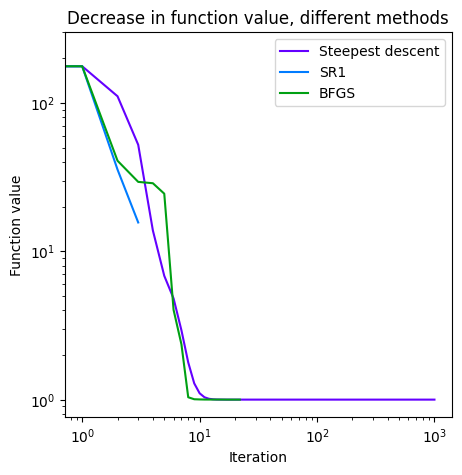

In [6]:
#Test them

# Initial parameters
maxIter = 1000
alpha0 = 1
beta = 0.8
tol = 1e-12

ns = [3, 6, 9, 12, 15, 18, 21, 24]

# First, for n = 24 we plot the decrease in the function value

n = 24
x0 = 2*np.ones((n, 1))
H0 = np.identity(n)

xn_steep, F_vec_steep, i_steep = steepDesc(x0)

xn_sr1, F_vec_sr1, i_sr1 = sr1(x0, H0)

xn_bfgs, F_vec_bfgs, i_bfgs = bfgs(x0, H0)

# Plot

plt.figure(figsize = (5, 5))
plt.loglog(range(0, i_steep+1), F_vec_steep, 
           c = "#6400ff", label = "Steepest descent")
plt.loglog(range(0, i_sr1+1), F_vec_sr1, 
           c = "#007cff", label = "SR1")
plt.loglog(range(0, i_bfgs+1), F_vec_bfgs, 
           c = "#00a013", label = "BFGS")
plt.legend()
plt.title("Decrease in function value, different methods")
plt.xlabel("Iteration")
plt.ylabel("Function value")

In [7]:
# Now we compute a table

from tabulate import tabulate

steps_steepest = []
steps_sr1 = []
steps_bfgs = []

min_steepest = []
min_sr1 = []
min_bfgs = []

for n in ns:
    x0 = 2*np.ones((n, 1))
    H0 = np.identity(n)
    xn_steep, F_vec_steep , i_steep = steepDesc(x0)
    steps_steepest += [i_steep]
    min_steepest += [F_vec_steep[-1] ]
    
    xn_sr1, F_vec_sr1, i_sr1 = sr1(x0, H0)
    steps_sr1 += [i_sr1]
    min_sr1 += [F_vec_sr1[-1]]
    
    xn_bfgs, F_vec_bfgs, i_bfgs = bfgs(x0, H0)
    steps_bfgs += [i_bfgs]
    min_bfgs += [F_vec_bfgs[-1]]

table_steps = {"n": ns, "Steepest descent": steps_steepest, 
               "SR1": steps_sr1, "BFGS": steps_bfgs}

print("Number of steps needed")
print(tabulate(table_steps, headers="keys", tablefmt="simple_grid") )

table_min = {"n": ns, "Steepest descent": min_steepest, 
             "SR1": min_sr1, "BFGS": min_bfgs}

print("\n\nMinimum found")
print(tabulate(table_min, headers="keys", tablefmt="simple_grid") )

Number of steps needed
  n    Steepest descent    SR1    BFGS
---  ------------------  -----  ------
  3                1000      3      11
  6                1000     14      16
  9                1000      9      16
 12                1000     12      18
 15                1000      3      16
 18                1000      3      24
 21                1000      3      21
 24                1000      3      22


Minimum found
  n    Steepest descent       SR1    BFGS
---  ------------------  --------  ------
  3             3.58177   1.99794       1
  6             1         1             1
  9             1         1             1
 12             4.26483   1             1
 15             1.3238    7.28015       1
 18             1        10.3462        1
 21             1        13.1719        1
 24             1        15.6442        1
